In [1]:
%matplotlib inline

import os 
import glob 
import sys
sys.path.append('/home/ngr4/project/edge_feat/scripts')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils
import load_data as data
import math
import numpy as np
import pandas as pd
import seaborn as sns
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import graphtools as gt
import phate
import umap
from sklearn.preprocessing import MinMaxScaler



plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

In [2]:
class Encoder(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, s_max, d_model, num_heads, ln=False, skip=True):
        super(Encoder, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.skip = skip
        self.s_max = s_max
        #Maximum set size
        self.d_model = d_model
        self.fc_q = nn.Linear(dim_Q, d_model)
        self.fc_k = nn.Linear(dim_K, d_model)
        self.fc_v = nn.Linear(dim_K, d_model)
        if ln:
            self.ln0 = nn.LayerNorm(d_model)
            self.ln1 = nn.LayerNorm(d_model)
        #This is the classic pointwise feedforward in "Attention is All you need"
        self.ff = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.ReLU(),
        nn.Linear(4 * d_model, d_model))
        self.fc_rep = nn.Linear(s_max, 1)
        
    # number of heads must divide output size = d_model
    def forward(self, Q, K, return_attention, return_A):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)
        dim_split = self.d_model // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
        A = torch.softmax(Q_.bmm(K_.transpose(-2,-1))/math.sqrt(self.d_model), dim=-1)
        A_1 = A.bmm(V_) 
        O = torch.cat((A_1).split(Q.size(0), 0), 2) 
        if return_attention:
            attn = O
        O = torch.cat((Q_ + A_1).split(Q.size(0), 0), 2) if getattr(self, 'skip', True) else \
             torch.cat((A_1).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)

        # For the classic transformers paper it is
        O = O + self.ff(O)
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        O = O.transpose(-2,-1)
        O = F.pad(O, (0, self.s_max- O.shape[-1]), 'constant', 0)
        O = self.fc_rep(O)
        O = O.squeeze() 
        if return_attention:
            return O, attn
        elif return_A:
            return O, A
        else:
            return O
    
class SelfAttention_batch(nn.Module):
    def __init__(self, s_max, dim_in=18, dim_out=8, num_heads=2, ln=True, skip=True):
        super(SelfAttention_batch, self).__init__()
        self.Encoder = Encoder(dim_in, dim_in, dim_in, s_max, dim_out, num_heads, ln=ln, skip=skip)
        
    def forward(self, X, return_attention=True, return_A=False):
        return self.Encoder(X, X, return_attention, return_A)
    
    
class GAT_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GAT_transformer_mlp_batch, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        x = F.elu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x, attn_gat2 = self.gat2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans, attn_gat1, attn_gat2
    
class GCN_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GCN_transformer_mlp_batch, self).__init__()
        self.conv1 = GCNConv(d.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans
    
    
    
def load_pkl(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

In [3]:
def main(d, **kwargs):
    
    batch_it = False 
   
    s_max = kwargs['s_max']
    if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        model = GCN_transformer_mlp_batch()
    elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        model = GAT_transformer_mlp_batch()
    model.eval()
    model.load_state_dict(torch.load(kwargs['modeleval_pkl'], map_location=torch.device('cpu')))
    
    if batch_it:
        # TODO: not implemented for GCN 
        cd_test = data.ClusterData(d,5000)
        cl_test = data.ClusterLoader(cd_test,256,shuffle=True)

        batch_loss_test = []
        batch_acc_test = []

        for batch in cl_test:
            output, attn_trans, attn_gat1, attn_gat2 = model(batch, utils.edge_set_reshape(batch).float())
            loss_test = F.nll_loss(output, batch.y)
            batch_acc_test.append(utils.accuracy(output,batch.y).item())
            batch_loss_test.append(loss_test.item())
        print('Test set results:')
        print('  <loss>_bacth={:.4f}'.format(np.mean(batch_loss_test)))
        print('  <acc>_batch ={:.4f}'.format(np.mean(batch_acc_test)))
    else:
        if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            output, attn_trans = model(d, utils.edge_set_reshape(d).float())
        elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            output, attn_trans, attn_gat1, attn_gat2 = model(d, utils.edge_set_reshape(d).float())
        loss_test = F.nll_loss(output, d.y)
        acc_test = utils.accuracy(output,d.y).item()
        print('Test set results:')
        print('  loss: {:.4f}'.format(loss_test))
        print('  accuracy: {:.4f}'.format(acc_test))
        
    datapkl = load_pkl(kwargs['data_pkl'])
    return attn_trans, attn_gat1, datapkl, model # returns for only one batch if batch_it = True

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ss(x):
    """Sum of squares divided by sqrt N."""
    return np.sum(x**2)/np.sqrt(x.shape[0])

In [82]:

params = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gattransmlpbatch/581-hbec_it_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gattransmlpbatch',
        's_max': 36, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params_gcn = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gcntransmlpbatch/705-hbec_gt_gcntransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gcntransmlpbatch',
        's_max': 41, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

pfp = '/home/ngr4/project/edge_feat/results'

In [83]:
%%time
kwargs = params
# NOTE: have to redefine class 
d = data.get_data(kwargs['data_pkl'], kwargs['label'], 
                       kwargs['sample'], None, 
                       kwargs['load_attn1'], kwargs['load_attn2'],
                       kwargs['modelpkl_fname1'], kwargs['modelpkl_fname2'],
                       kwargs['preloadn2v'], out_channels=8, 
                       heads=8, negative_slope=0.2, 
                       dropout=0.4)


Forman curvature per 228630 edges
Dot prod per 228630 edges
CPU times: user 18.9 s, sys: 3.18 s, total: 22.1 s
Wall time: 16 s


/home/ngr4/project/edge_feat/scripts/load_data.py:505: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.cat((torch.tensor(attn, dtype=float),
/home/ngr4/project/edge_feat/scripts/load_data.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attn2, dtype=float),


In [85]:
s_max = kwargs['s_max'] # scope is incorrect when in fx
attn_trans, attn_gat1, datapkl, model = main(d, **kwargs)

Test set results:
  loss: 0.4776
  accuracy: 0.8342


## Gene features

In [88]:
featnames = load_pkl(os.path.join(pfp,'hbec_feat_names.pkl'))
n_top = 5
g_idx = []
n_heads = 8
n_hidden_units = 8
weight_per_headz = model.gat1.weight.detach().numpy().reshape(-1,n_heads,n_hidden_units, order='F')
for i in range(n_heads):
    [g_idx.append(i) for i in np.max(np.abs(weight_per_headz[:,:,i]),axis=1).argsort()[-n_top:]]
g_idx = np.unique(g_idx)
w_top = np.zeros([g_idx.shape[0],n_hidden_units,n_heads])
for i in range(n_heads):
    w_top[:,:,i] = weight_per_headz[g_idx,:,i]
w_top= w_top.reshape((w_top.shape[0],-1))
w_top = pd.DataFrame(w_top, index=[g for i,g in enumerate(featnames) if i in g_idx])


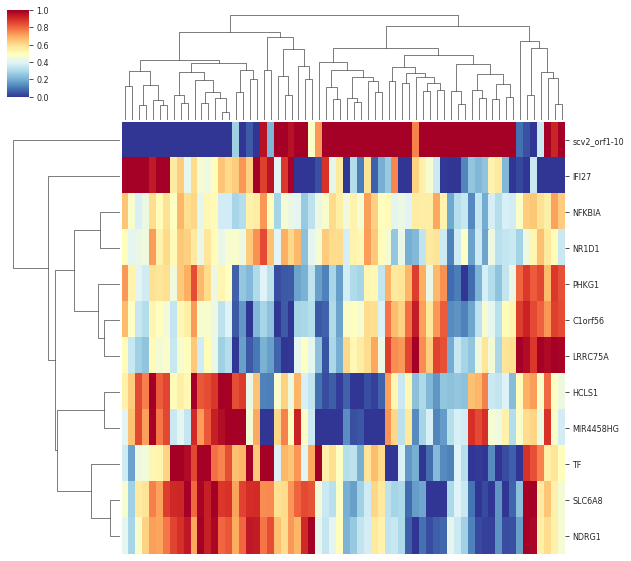

In [89]:
sns.clustermap(
    w_top,
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=1,
    figsize=None,
    cbar_kws=None,
    row_cluster=True,
    col_cluster=True,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=None,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    xticklabels=False
)


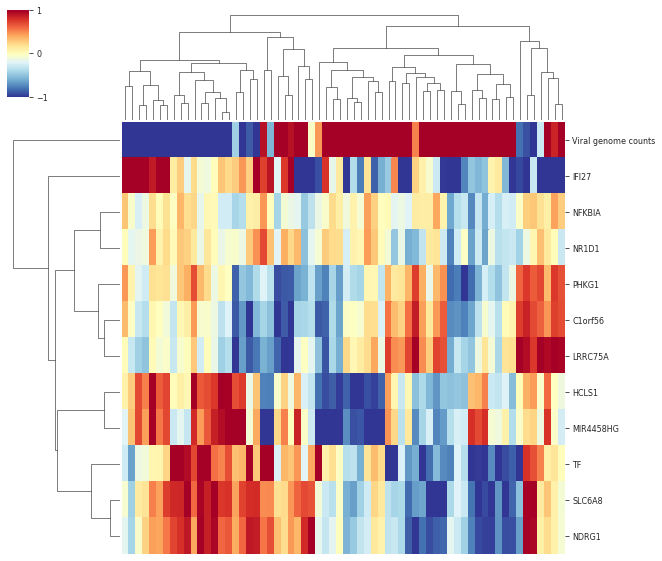

In [100]:
w_top_scaled = pd.DataFrame(MinMaxScaler(feature_range=(-1,1)).fit_transform(w_top), index=w_top.index)
w_top_scaled = w_top_scaled.rename(index={'scv2_orf1-10':'Viral genome counts'})
p = sns.clustermap(
        w_top_scaled,
        pivot_kws=None,
        method='average',
        metric='euclidean',
        z_score=None,
        standard_scale=None,
        figsize=None,
        row_cluster=True,
        col_cluster=True,
        row_linkage=None,
        col_linkage=None,
        row_colors=None,
        col_colors=None,
        mask=None,
        cmap='RdYlBu_r',
        yticklabels=True,
        xticklabels=False,
        cbar_kws={'ticks':[-1,0,1]}
)

p.savefig(os.path.join(pfp,'hbec_top5_gene_weight.pdf'), bbox_inches='tight')

## Edge attentions, Set Transformer

Text(0.5, 0.98, 'Weight, softmax across rows')

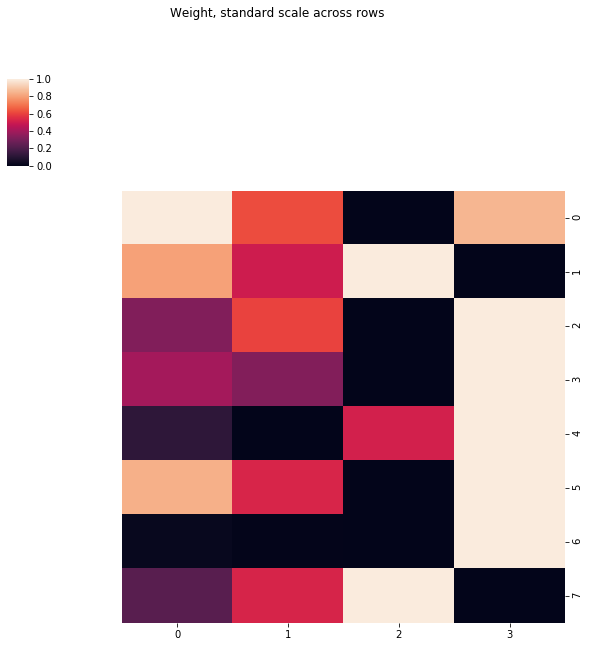

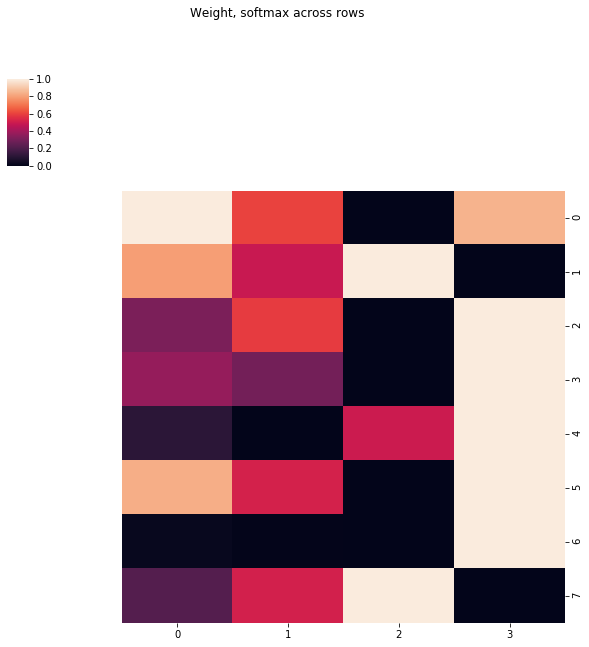

In [376]:
weight_mat = model.transformer.Encoder.fc_q.weight.abs().detach().numpy()
aveq = np.zeros((8,4))
aveq[:,-2:] = weight_mat[:,-2:]
aveq[:,0] = np.mean(weight_mat[:,0:8], axis=1)
aveq[:,1] = np.mean(weight_mat[:,8:16], axis=1)

# scale rows
p = sns.clustermap(aveq, row_cluster=False, col_cluster=False,
                   standard_scale=0)
p.fig.suptitle('Weight, standard scale across rows')

# softmax
p2 = sns.clustermap(np.apply_along_axis(softmax, 1, aveq), 
                    row_cluster=False, col_cluster=False,
                    standard_scale=0)
p2.fig.suptitle('Weight, softmax across rows')


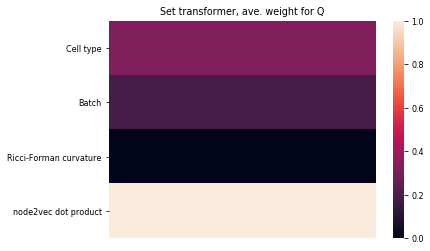

In [389]:

mean_aveq = np.apply_along_axis(np.mean, 0, aveq)
mean_aveq = (mean_aveq - np.min(mean_aveq)) / (np.max(mean_aveq) - np.min(mean_aveq))
p4 = sns.heatmap(mean_aveq.reshape(-1,1), xticklabels=False, 
                 yticklabels=['Cell type', 'Batch', 'Ricci-Forman curvature', 'node2vec dot product'])
p4.set_title('Set transformer, ave. weight for Q')
fig = p4.get_figure()
fig.savefig(os.path.join(pfp,'edge_feat_weight.pdf'), bbox_inches='tight')

In [488]:
%%time

# select interesting cells 
metadata = pd.DataFrame({'Condition':datapkl['Condition'], 
                         'Cell type':datapkl['ctype'],
                         'Infected':datapkl['scv2_10+'],
                         'i':list(range(len(datapkl['ctype'])))})

# get interesting info (cell type) per connection
metadata['js'] = metadata['i'].apply(lambda x: d.edge_index[1,np.where(d.edge_index[0,:]==x)[0]].tolist())
metadata['n_e'] = metadata['js'].apply(lambda x:len(x))
metadata['js_ctype'] = metadata['js'].apply(lambda x:metadata.loc[x,'Cell type'].to_list()) # assumes i and index correspond

# count cell type connections
for ctype in metadata['Cell type'].unique():
    metadata['n_{}'.format(ctype)] = metadata['js_ctype'].apply(lambda x:np.sum([True if c==ctype else False for c in x]))
    metadata['p_{}'.format(ctype)] = metadata['n_{}'.format(ctype)] / metadata['n_e']
    
# calculate p_infected in js
metadata['p_infected'] = metadata['js'].apply(lambda x: np.sum([metadata.loc[j,'Infected']==1 for j in x])/len(x))

# take only cells with ciliated cells connected to other cell types
# take only infected (or uninfected) that are connected to a low proportion of infected
mdsub = metadata.loc[(metadata['Condition']=='3dpi') & 
            (metadata['Cell type']=='Ciliated cells') & 
            (metadata['Infected']==1) &
            (metadata['p_Ciliated cells']<1), :]
metadata['i_ofinterest'] = metadata['i'].isin(mdsub['i'])
# sns.distplot(mdsub['p_infected'], color='gray') # are cells of interest to label?

# get unique cells connected to i
j_ofinterest = []
for i in mdsub.loc[:,'js']:
    j_ofinterest += i
j_ofinterest_unique = list(set(j_ofinterest) - set(mdsub['i']))
metadata['j_ofinterest_unique'] = metadata['i'].isin(j_ofinterest_unique)
metadata['coi'] = 'Background'
metadata.loc[metadata['i_ofinterest'],'coi'] = 'Infected ciliated cells connected to non-ciliated cells'
metadata.loc[metadata['j_ofinterest_unique'],'coi'] = 'Unique cell connections'

CPU times: user 12.1 s, sys: 109 ms, total: 12.2 s
Wall time: 8.05 s


In [101]:
i = d.edge_index[0,:].numpy()
j = d.edge_index[1,:].numpy()

# approach 1: try sum of squares 
if False:
    attn_i = np.apply_along_axis(ss, 1, attn_trans[:,0,:].detach().numpy())
    attn_e = np.mean(np.column_stack((attn_i[i], attn_i[j])), axis=1)
    adj = coo_matrix((attn_e, (i,j))).tocsr() # there is self-loops; adj[0:3,0:3]; np.sum(adj[:,0])

    ## phate
    G = gt.Graph(data=adj,
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=0,
                           n_jobs=-1)
    data_phate=phate_op.fit_transform(G.K)

    ## plot
    cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    sns.scatterplot(
        x=data_phate[:,0],
        y=data_phate[:,1],
        hue=datapkl['yinftime'],
    #     palette=cmap_inftime,
        ax=ax,
        linewidth=0,
        s=1,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PHATE1')
    ax.set_ylabel('PHATE2')
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_title('Set transformer, SS edge attentions')


# approach 2: average
attn_i = np.apply_along_axis(np.mean, 1, attn_trans[:,0,:].detach().numpy())
attn_e = np.mean(np.column_stack((attn_i[i], attn_i[j])), axis=1)
adj = coo_matrix((attn_e, (i,j))).tocsr() # there is self-loops; adj[0:3,0:3]; np.sum(adj[:,0])

## phate
G = gt.Graph(data=adj,
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None
phate_op = phate.PHATE(knn_dist='precomputed',
                       gamma=0,
                       n_jobs=-1)
data_phate=phate_op.fit_transform(G.K)

## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_phate[:,0],
    y=data_phate[:,1],
    hue=datapkl['yinftime'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')


# approach 3: average of softmax 

In [508]:
cmap_coi = {'Unique cell connections':sns.color_palette('colorblind')[5],
           'Infected ciliated cells connected to non-ciliated cells':sns.color_palette('colorblind')[6],
           'Background':'k'}

In [512]:
temp = data_phate
temp[metadata['coi']=='Background',:] = np.nan

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

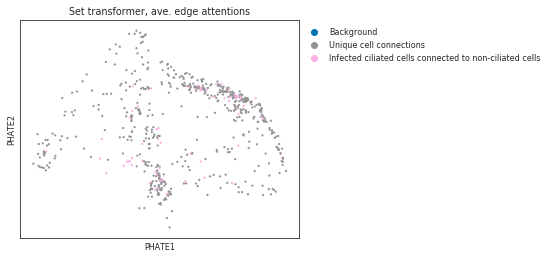

In [520]:
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
cmap_coi = {'Unique cell connections':sns.color_palette('colorblind')[7],
           'Infected ciliated cells connected to non-ciliated cells':sns.color_palette('colorblind')[6],
           'Background':sns.color_palette('colorblind')[0]}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=temp[:,0],
    y=temp[:,1],
    hue=metadata['coi'].to_list(),
    palette=cmap_coi,
    ax=ax,
    linewidth=0,
    s=5,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

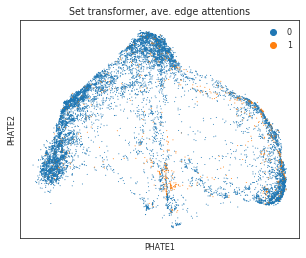

In [539]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_phate[:,0],
    y=data_phate[:,1],
    hue=datapkl['scv2_10+'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

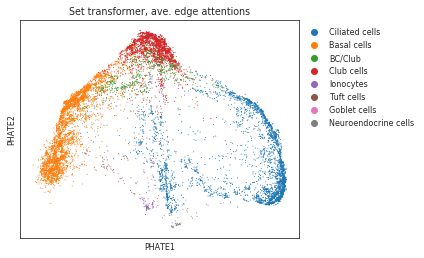

In [540]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_phate[:,0],
    y=data_phate[:,1],
    hue=datapkl['ctype'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

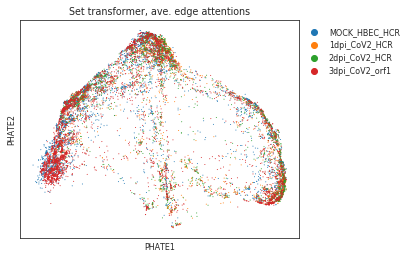

In [541]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_phate[:,0],
    y=data_phate[:,1],
    hue=datapkl['batch'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

In [102]:
data_umap = umap.UMAP(metric='cosine').fit_transform(adj)


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../conda_envs/rnavel/lib/python3.7/site-packages/umap/sparse.py", line 176:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


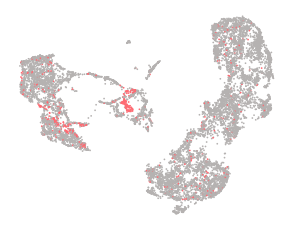

In [106]:
## plot
cmap_infected = {1:'#FE6B73',
                 0:'#B5B2B1'}
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['scv2_10+'],
    palette=cmap_infected,
    ax=ax,
    linewidth=0,
    s=3,
    rasterized=True,
)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
ax.axis('off')
fig.savefig(os.path.join(pfp,'hbec_umap_fromedgeattn_infected.pdf'), bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

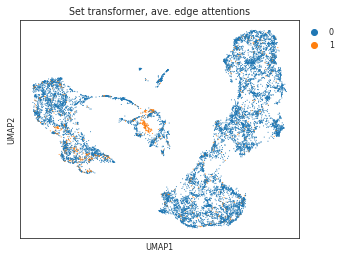

In [535]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['scv2_10+'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend().set
ax.set_title('Set transformer, ave. edge attentions')

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

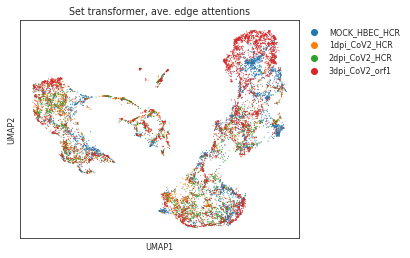

In [542]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['batch'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

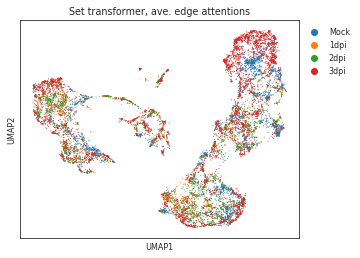

In [536]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['Condition'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

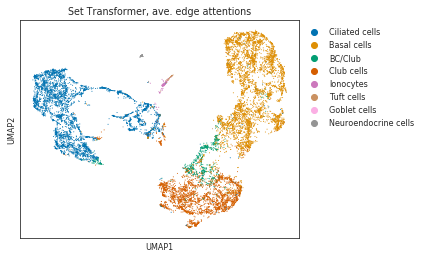

In [107]:
## plot
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['ctype'],
    palette=sns.color_palette('colorblind')[0:8],
    ax=ax,
    linewidth=0,
    s=1,
    rasterized=True,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set Transformer, ave. edge attentions')
fig.savefig(os.path.join(pfp,'hbec_umap_fromedgeattn_ctype.pdf'), bbox_inches='tight', dpi=300)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

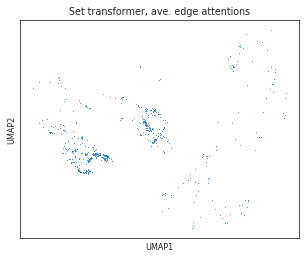

In [534]:
cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=temp[:,0],
    y=temp[:,1],
#     hue=datapkl['scv2_10+'][metadata['coi']!='Background'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 11648 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.72 seconds.
    Calculating KMeans...
    Calculated KMeans in 23.40 seconds.
  Calculated landmark operator in 25.63 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.70 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 31.04 seconds.
Calculated PHATE in 58.79 seconds.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 11648 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.72 seconds.
    Calculating KMeans...
    Calculated KMeans in 15.28

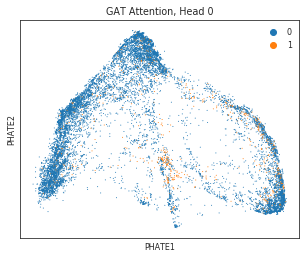

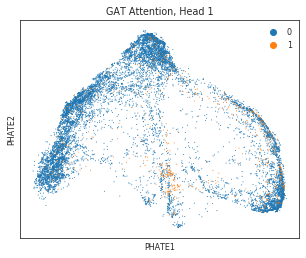

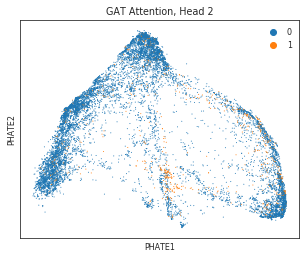

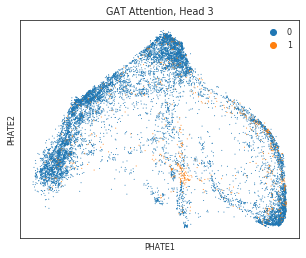

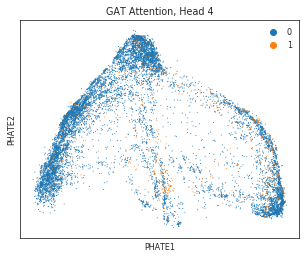

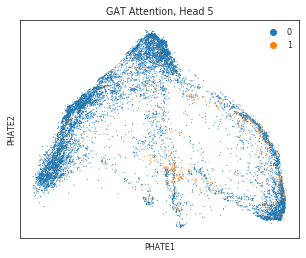

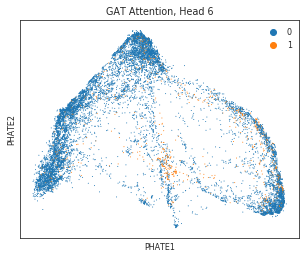

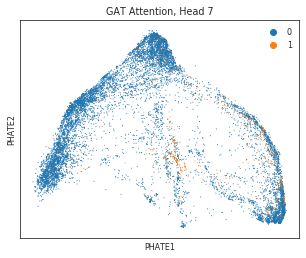

In [552]:
# compare to GAT attn
for h in range(8):
    adj = coo_matrix((attn_gat1[:,h].detach(), (i,j))).tocsr() # there is self-loops; adj[0:3,0:3]; np.sum(adj[:,0])
    G = gt.Graph(data=adj,
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=0,
                           n_jobs=-1)
    data_phate=phate_op.fit_transform(G.K)

    ## plot
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    sns.scatterplot(
        x=data_phate[:,0],
        y=data_phate[:,1],
        hue=datapkl['scv2_10+'],
    #     palette=cmap_inftime,
        ax=ax,
        linewidth=0,
        s=1,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PHATE1')
    ax.set_ylabel('PHATE2')
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_title('GAT Attention, Head {}'.format(h))
    

Text(0.5, 1.0, 'GAT Attention, Head 7')

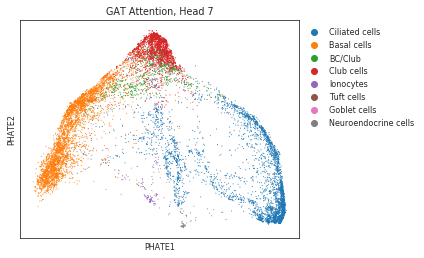

In [553]:
# look at the last one 

## plot
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_phate[:,0],
    y=data_phate[:,1],
    hue=datapkl['ctype'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('GAT Attention, Head {}'.format(h))

# COVID-19 pt samples dataset 

In [6]:
params_liao = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/liao/cond_gattransmlpbatch/1025-liao_cond_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/covid_lung/data/processed/liao_test_200529.pkl',
        'sample':'liao_cond_gattransmlpbatch',
        's_max': 70, # get from log, 
        'label':'ycondition',
        'model':'GAT_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/covid_lung/data/processed/887-liao_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/covid_lung/data/processed/1988-liao_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

In [7]:
%%time
kwargs = params_liao
# NOTE: have to redefine class 
d = data.get_data(kwargs['data_pkl'], kwargs['label'], 
                       kwargs['sample'], None, 
                       kwargs['load_attn1'], kwargs['load_attn2'],
                       kwargs['modelpkl_fname1'], kwargs['modelpkl_fname2'],
                       kwargs['preloadn2v'], out_channels=8, 
                       heads=8, negative_slope=0.2, 
                       dropout=0.4)


Forman curvature per 707529 edges
Dot prod per 707529 edges
CPU times: user 28.8 s, sys: 4.21 s, total: 33 s
Wall time: 20.8 s


/home/ngr4/project/edge_feat/scripts/load_data.py:505: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.cat((torch.tensor(attn, dtype=float),
/home/ngr4/project/edge_feat/scripts/load_data.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attn2, dtype=float),


In [11]:
s_max = kwargs['s_max'] # scope is incorrect when in fx
attn_trans, attn_gat1, datapkl, model = main(d, **kwargs)

Test set results:
  loss: 0.1162
  accuracy: 0.9565


Text(0.5, 0.98, 'Weight, softmax across rows')

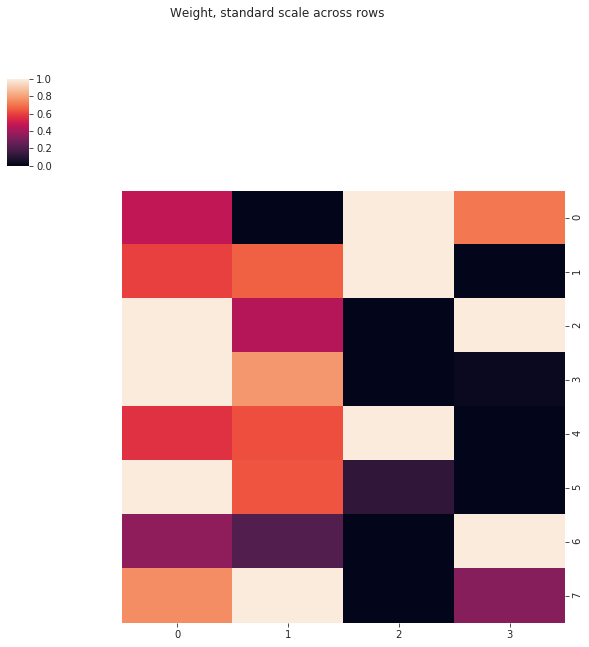

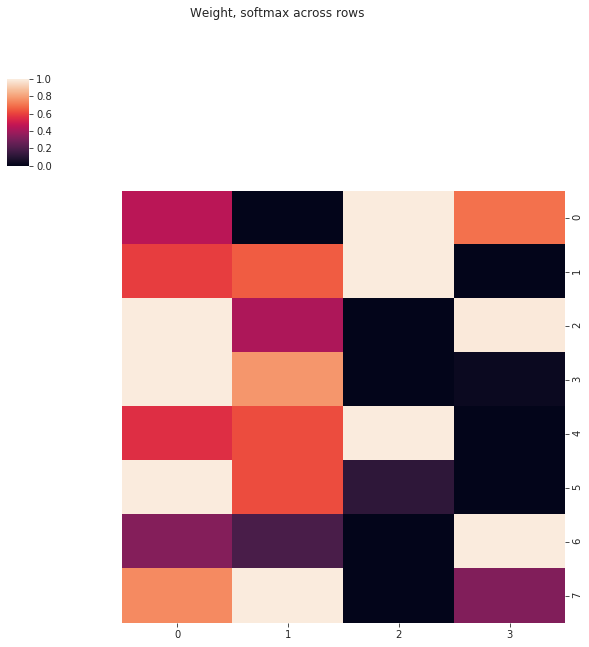

In [12]:
weight_mat = model.transformer.Encoder.fc_q.weight.abs().detach().numpy()
aveq = np.zeros((8,4))
aveq[:,-2:] = weight_mat[:,-2:]
aveq[:,0] = np.mean(weight_mat[:,0:8], axis=1)
aveq[:,1] = np.mean(weight_mat[:,8:16], axis=1)

# scale rows
p = sns.clustermap(aveq, row_cluster=False, col_cluster=False,
                   standard_scale=0)
p.fig.suptitle('Weight, standard scale across rows')

# softmax
p2 = sns.clustermap(np.apply_along_axis(softmax, 1, aveq), 
                    row_cluster=False, col_cluster=False,
                    standard_scale=0)
p2.fig.suptitle('Weight, softmax across rows')


In [14]:
pfp = '/home/ngr4/project/edge_feat/results'

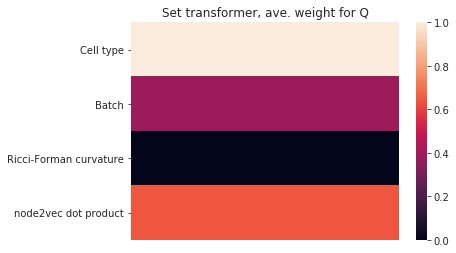

In [15]:

mean_aveq = np.apply_along_axis(np.mean, 0, aveq)
mean_aveq = (mean_aveq - np.min(mean_aveq)) / (np.max(mean_aveq) - np.min(mean_aveq))
p4 = sns.heatmap(mean_aveq.reshape(-1,1), xticklabels=False, 
                 yticklabels=['Cell type', 'Batch', 'Ricci-Forman curvature', 'node2vec dot product'])
p4.set_title('Set transformer, ave. weight for Q')
fig = p4.get_figure()
fig.savefig(os.path.join(pfp,'liao_edgefeat_weight.pdf'), bbox_inches='tight')

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 13605 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.59 seconds.
    Calculating KMeans...
    Calculated KMeans in 21.61 seconds.
  Calculated landmark operator in 24.84 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.41 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.54 seconds.
Calculated PHATE in 33.26 seconds.


Text(0.5, 1.0, 'Set transformer, ave. edge attentions')

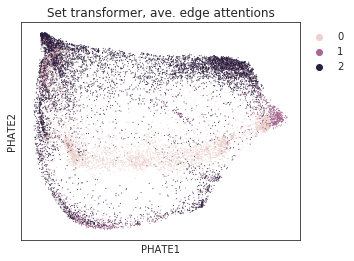

In [25]:
i = d.edge_index[0,:].numpy()
j = d.edge_index[1,:].numpy()

# approach 1: try sum of squares 
if False:
    attn_i = np.apply_along_axis(ss, 1, attn_trans[:,0,:].detach().numpy())
    attn_e = np.mean(np.column_stack((attn_i[i], attn_i[j])), axis=1)
    adj = coo_matrix((attn_e, (i,j))).tocsr() # there is self-loops; adj[0:3,0:3]; np.sum(adj[:,0])

    ## phate
    G = gt.Graph(data=adj,
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=0,
                           n_jobs=-1)
    data_phate=phate_op.fit_transform(G.K)

    ## plot
    cmap_inftime = {v:sns.color_palette('colorblind')[i] for i,v in enumerate(np.unique(datapkl['yinftime']))}
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    sns.scatterplot(
        x=data_phate[:,0],
        y=data_phate[:,1],
        hue=datapkl['yinftime'],
    #     palette=cmap_inftime,
        ax=ax,
        linewidth=0,
        s=1,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PHATE1')
    ax.set_ylabel('PHATE2')
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_title('Set transformer, SS edge attentions')


# approach 2: average
attn_i = np.apply_along_axis(np.mean, 1, attn_trans[:,0,:].detach().numpy())
attn_e = np.mean(np.column_stack((attn_i[i], attn_i[j])), axis=1)
adj = coo_matrix((attn_e, (i,j))).tocsr() # there is self-loops; adj[0:3,0:3]; np.sum(adj[:,0])

## phate
G = gt.Graph(data=np.abs(adj),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None
phate_op = phate.PHATE(knn_dist='precomputed',
                       gamma=0)
data_phate=phate_op.fit_transform(G.K)

## plot
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_phate[:,0],
    y=data_phate[:,1],
    hue=datapkl['ycondition'],
#     palette=cmap_inftime,
    ax=ax,
    linewidth=0,
    s=1,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set transformer, ave. edge attentions')


# approach 3: average of softmax 

In [28]:
data_umap = umap.UMAP(metric='cosine').fit_transform(adj)


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/umap/sparse.py:247: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../conda_envs/rnavel/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html

In [32]:
datapkl.keys()

dict_keys(['X', 'adj', 'feature_names', 'cell_id', 'batch', 'n_genes', 'louvain', 'init_ctype', 'Condition', 'ysevere', 'yctype', 'ycondition', 'ybatch'])

In [40]:
sns.color_palette('colorblind')+['red']

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 'red']

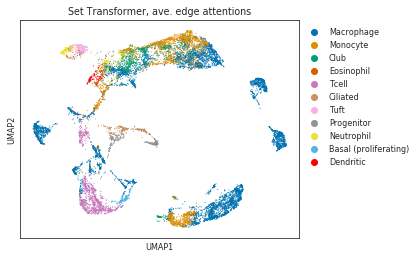

In [45]:
## plot
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['init_ctype'],
    palette=sns.color_palette('colorblind')+['red'],
    ax=ax,
    linewidth=0,
    s=1,
    rasterized=True,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set Transformer, ave. edge attentions')
fig.savefig(os.path.join(pfp,'liao_umap_fromedgeattn_ctype.pdf'), bbox_inches='tight', dpi=300)

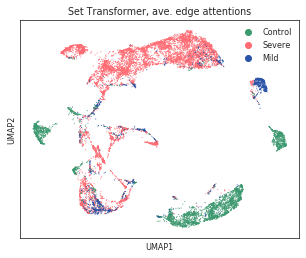

In [37]:
## plot
cmap_condition = {'Control':'#3D9970',
                  'Mild':'#2954A7',
                  'Severe':'#FE6B73'}
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['Condition'],
    palette=cmap_condition,
    ax=ax,
    linewidth=0,
    s=1,
    rasterized=True,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set Transformer, ave. edge attentions')
fig.savefig(os.path.join(pfp,'liao_umap_fromedgeattn_condition.pdf'), bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Set Transformer, ave. edge attentions')

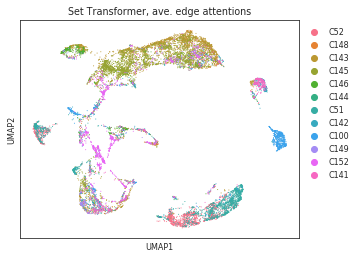

In [34]:
## plot
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(
    x=data_umap[:,0],
    y=data_umap[:,1],
    hue=datapkl['batch'],
#     palette=sns.color_palette('colorblind')[0:11],
    ax=ax,
    linewidth=0,
    s=1,
    rasterized=True,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Set Transformer, ave. edge attentions')
# fig.savefig(os.path.join(pfp,'liao_umap_fromedgeattn_ctype.pdf'), bbox_inches='tight', dpi=300)

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../conda_envs/rnavel/lib/python3.7/site-packages/umap/sparse.py", line 176:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../conda_envs/rnavel/lib/python3.7/site-packages/umap/sparse.py", 

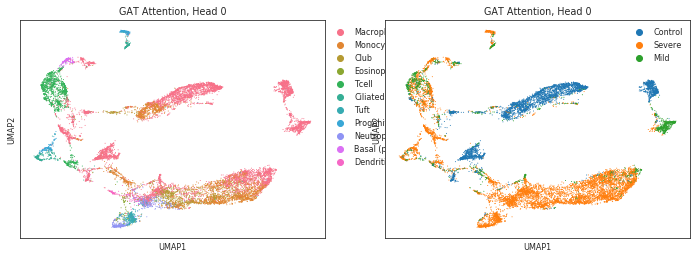

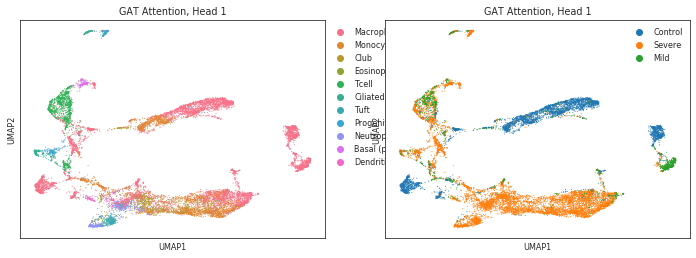

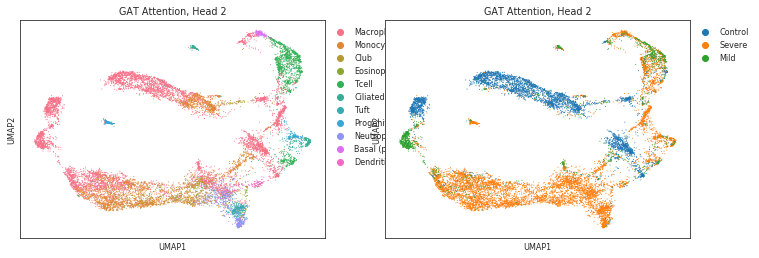

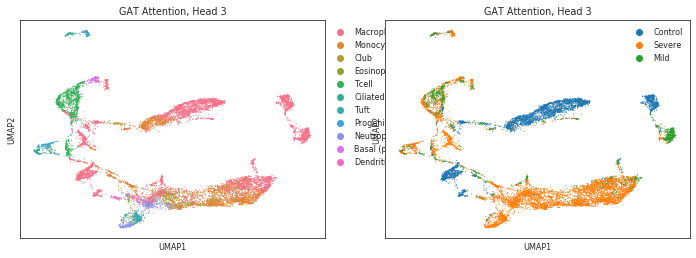

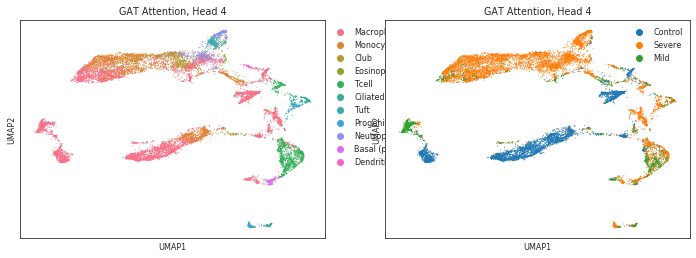

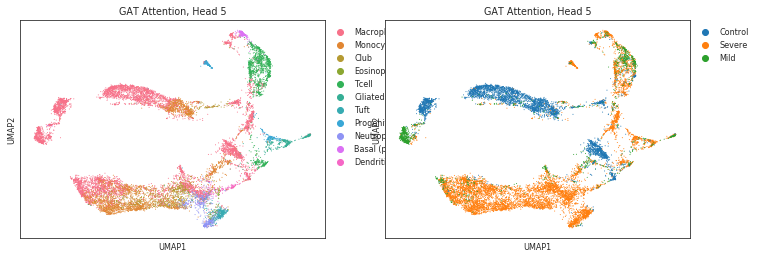

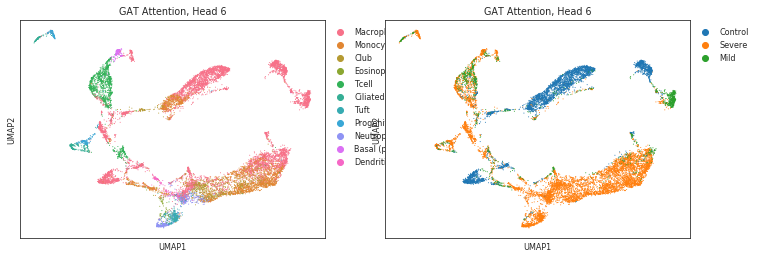

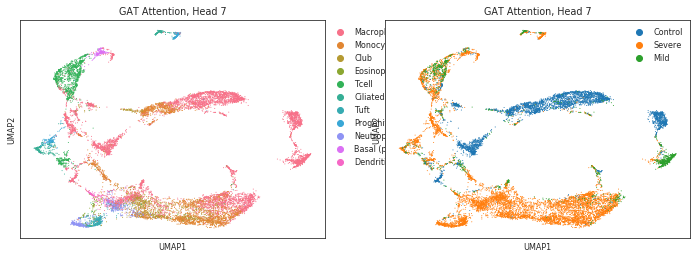

In [44]:
# GAT check to make sure separability with set transformer is better for ctype AND condition, rather than GAT attns
for h in range(8):
    adj = coo_matrix((attn_gat1[:,h].detach(), (i,j))).tocsr() # there is self-loops; adj[0:3,0:3]; np.sum(adj[:,0])
    phate=False
    if phate:
        G = gt.Graph(data=adj,
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        phate_op = phate.PHATE(knn_dist='precomputed',
                               gamma=0)
        data=phate_op.fit_transform(G.K)
        prefix = 'PHATE'
    else:
        prefix = 'UMAP'
        data = umap.UMAP(metric='cosine').fit_transform(adj)

    ## plot
    fig,ax=plt.subplots(1,2,figsize=(12,4))
    sns.scatterplot(
        x=data[:,0],
        y=data[:,1],
        hue=datapkl['init_ctype'],
        ax=ax[0],
        linewidth=0,
        s=1,
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel('{}1'.format(prefix))
    ax[0].set_ylabel('{}2'.format(prefix))
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GAT Attention, Head {}'.format(h))
    
    sns.scatterplot(
        x=data[:,0],
        y=data[:,1],
        hue=datapkl['Condition'],
        ax=ax[1],
        linewidth=0,
        s=1,
    )
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlabel('{}1'.format(prefix))
    ax[1].set_ylabel('{}2'.format(prefix))
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GAT Attention, Head {}'.format(h))    

## Gene importance 

In [63]:
featnames = load_pkl(os.path.join(pfp,'liao_feat_names.pkl'))
n_top = 5
g_idx = []
n_heads = 8
n_hidden_units = 8
weight_per_headz = model.gat1.weight.detach().numpy().reshape(-1,n_heads,n_hidden_units, order='F')
for i in range(n_heads):
    [g_idx.append(i) for i in np.max(np.abs(weight_per_headz[:,:,i]),axis=1).argsort()[-n_top:]]
g_idx = np.unique(g_idx)
w_top = np.zeros([g_idx.shape[0],n_hidden_units,n_heads])
for i in range(n_heads):
    w_top[:,:,i] = weight_per_headz[g_idx,:,i]
w_top= w_top.reshape((w_top.shape[0],-1))
w_top = pd.DataFrame(w_top, index=[g for i,g in enumerate(featnames) if i in g_idx])


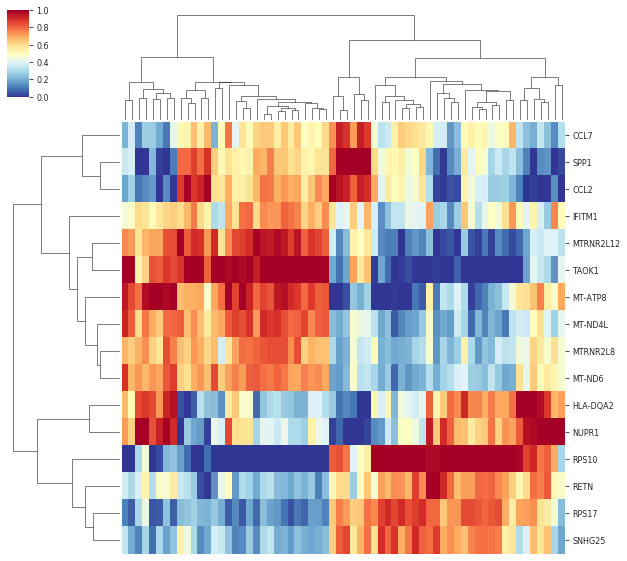

In [66]:
sns.clustermap(
    w_top,
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=1,
    figsize=None,
    cbar_kws=None,
    row_cluster=True,
    col_cluster=True,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=None,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    xticklabels=False
)

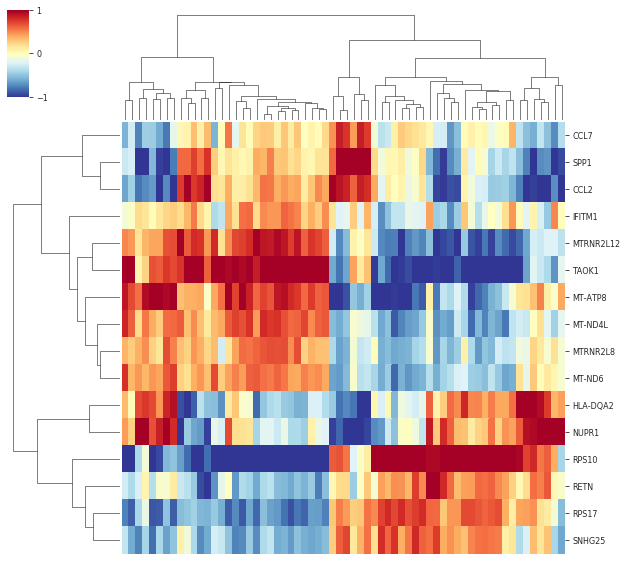

In [75]:

w_top_scaled = pd.DataFrame(MinMaxScaler(feature_range=(-1,1)).fit_transform(w_top), index=w_top.index)
p = sns.clustermap(
        w_top_scaled,
        pivot_kws=None,
        method='average',
        metric='euclidean',
        z_score=None,
        standard_scale=None,
        figsize=None,
        row_cluster=True,
        col_cluster=True,
        row_linkage=None,
        col_linkage=None,
        row_colors=None,
        col_colors=None,
        mask=None,
        cmap='RdYlBu_r',
        yticklabels=True,
        xticklabels=False,
        cbar_kws={'ticks':[-1,0,1]}
)

p.savefig(os.path.join(pfp,'liao_top5_gene_weight.pdf'), bbox_inches='tight')

# MS

In [ ]:
params_ms = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/scni/gatours/1144-scni_ms_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/scni/data/processed_200108/scni_val_200604.pkl',
        'sample':'scni_ms_gattransmlpbatch',
        's_max': 85, # get from log, 
        'label':'yms',
        'model':'GAT_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/scni/data/processed_200108/1973-scni_ctype1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/scni/data/processed_200108/1996-scni_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

kwargs = params_ms
# NOTE: have to redefine class 
d = data.get_data(kwargs['data_pkl'], kwargs['label'], 
                       kwargs['sample'], None, 
                       kwargs['load_attn1'], kwargs['load_attn2'],
                       kwargs['modelpkl_fname1'], kwargs['modelpkl_fname2'],
                       kwargs['preloadn2v'], out_channels=8, 
                       heads=8, negative_slope=0.2, 
                       dropout=0.4)

s_max = kwargs['s_max'] # scope is incorrect when in fx
attn_trans, attn_gat1, datapkl, model = main(d, **kwargs)

Forman curvature per 2635746 edges
Dot prod per 2635746 edges


/home/ngr4/project/edge_feat/scripts/load_data.py:505: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.cat((torch.tensor(attn, dtype=float),
/home/ngr4/project/edge_feat/scripts/load_data.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attn2, dtype=float),
